# Compare TSPMe model with experimental data

In this notebook we compare the TSPMe simulations with experimental data, which corresponds to Section 4.2 of the paper. The results in the section can also be generated running the script `scripts/compare_TSPMe_data.py`. The main difference is that in the script the different functions are wrapped as functions while here they are explicitly written.

The goal of this notebook is to compare the reduced model (TSPMe) against experimental data to validate the resuts of the former.

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from os import path
from tec_reduced_model.set_parameters import (
    set_thermal_parameters,
    set_experiment_parameters,
    set_ambient_temperature,
)
from tec_reduced_model.process_experimental_data import import_thermal_data, get_idxs

plt.style.use(['science','vibrant'])

plt.rcParams.update({
    "font.family": "sans-serif",
    "text.usetex": False,
    "font.size": 8,
    "axes.labelsize": 10,
})

ModuleNotFoundError: No module named 'tec_reduced_model'

We first need to define the simulations parameters:

In [ ]:
# Change simulation parameters here
temperature = 25  # in degC, valid values: 0, 10, 25
Crate = 1         # valid values: 0.5, 1, 2
cells_ignore = ["791"]    # cells to ignore, in this case we ignore cell 791 because the data for that cell is faulty

Then, we set model and solve the simulation.

In [3]:
# Define the TSPMe model
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

# Define parameter set Chen 2020 (see PyBaMM documentation for details)
# This is the reference parameter set, which we then update for the adjusted thermal parameters
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

# We now update the parameter set for the adjusted parameters
param = set_thermal_parameters(param, 16, 2.32e6, temperature)
param = set_experiment_parameters(param, Crate, temperature)
param = set_ambient_temperature(param, Crate, temperature)

# Define the experiment to be a CC discharge at the defined C-rate followed by a 2-hour relaxation
experiment = pybamm.Experiment(
    [
        "Discharge at {}C until 2.5 V (5 seconds period)".format(Crate),
        "Rest for 2 hours",
    ],
    period="30 seconds",
)

# Solve the model
simulation = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=experiment,
)
simulation.solve()
solution = simulation.solution

Next, we import the experimental data and plot it against the TSPMe simulation. We also concatenate the data of the different cells to compute the error late on.

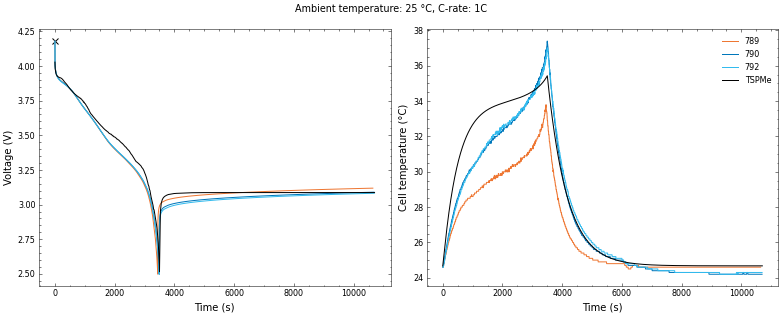

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
dataset = import_thermal_data(Crate, temperature)
data_conc = {"time": [], "voltage": [], "temperature": []}

for cell, data in dataset.items():
    if cell in cells_ignore:
        continue

    idx_start, idx_end = get_idxs(data, Crate * 5, 5 / 3)
    if len(idx_end) == 1:
        idx_end = np.append(idx_end, len(data["Time [s]"]))

    axes[0].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Voltage [V]"][idx_start[0] : idx_end[1]],
        label=cell,
    )
    axes[1].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
        label=cell,
    )

    data_conc["time"] = np.append(
        data_conc["time"],
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
    )
    data_conc["voltage"] = np.append(
        data_conc["voltage"], data["Voltage [V]"][idx_start[0] : idx_end[1]]
    )
    data_conc["temperature"] = np.append(
        data_conc["temperature"],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
    )

    
axes[0].plot(
    solution["Time [s]"].entries,
    solution["Terminal voltage [V]"].entries,
    color="black",
    label="TSPMe",
)

axes[0].scatter(
    0,
    solution["X-averaged battery open circuit voltage [V]"].entries[0],
    marker="x",
    color="black",
)

axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Voltage (V)")

axes[1].plot(
    solution["Time [s]"].entries,
    solution["X-averaged cell temperature [K]"].entries - 273.15,
    color="black",
    label="TSPMe",
)

axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Cell temperature (°C)")
axes[1].legend()
    
fig.suptitle("Ambient temperature: {} °C, C-rate: {}C".format(temperature, Crate))    

fig.tight_layout()
fig.subplots_adjust(top=0.9)

We now compute the error between the TSPMe and experimental data and print the R^2 and RMSE for both voltage and temperature:

In [5]:
def rmse(solution, x_data, y_data):
    error = solution(x_data) - y_data
    error = error[~np.isnan(error)]  # remove NaNs due to extrapolation
    return np.sqrt(np.mean(error ** 2))


def R_squared(solution, x_data, y_data):
    y_bar = np.mean(y_data)
    SS_tot = np.sum((y_data - y_bar) ** 2)
    res = y_data - solution(x_data)
    res = res[~np.isnan(res)]  # remove NaNs due to extrapolation
    SS_res = np.sum(res ** 2)

    return 1 - SS_res / SS_tot

error = {}
error["RMSE_V"] = rmse(
    solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"]
)
error["Rsq_V"] = R_squared(
    solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"]
)
error["RMSE_T"] = rmse(
    solution["X-averaged cell temperature [K]"],
    data_conc["time"],
    data_conc["temperature"] + 273.15,
)
error["Rsq_T"] = R_squared(
    solution["X-averaged cell temperature [K]"],
    data_conc["time"],
    data_conc["temperature"] + 273.15,
)

print("Voltage RMSE: {:.2f} mV".format(error["RMSE_V"] * 1000))
print("Voltage R^2: {:.4f}".format(error["Rsq_V"]))
print("Temperature RMSE: {:.2f} °C".format(error["RMSE_T"]))
print("Temperature R^2: {:.4f}".format(error["Rsq_T"]))

Voltage RMSE: 49.94 mV
Voltage R^2: 0.9643
Temperature RMSE: 1.46 °C
Temperature R^2: 0.8282
